In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import RandomHorizontalFlip, Resize, ColorJitter, ToTensor, Normalize, Compose
from torchvision.models import efficientnet_b0, vgg16
from torchmetrics.functional import structural_similarity_index_measure as ssim_func
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, input_dir, target_dir, resize_to=(256, 256)):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.input_files = os.listdir(input_dir)
        self.resize_to = resize_to

        self.transform_gray = Compose([
            Resize(resize_to),
            RandomHorizontalFlip(),
            ToTensor(),
            Normalize(mean=[0.5], std=[0.5])
        ])

        self.transform_rgb = Compose([
            Resize(resize_to),
            RandomHorizontalFlip(),
            ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            ToTensor(),
            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        target_path = os.path.join(self.target_dir, self.input_files[idx])

        input_image = Image.open(input_path).convert("L")
        target_image = Image.open(target_path).convert("RGB")

        input_image = self.transform_gray(input_image)
        target_image = self.transform_rgb(target_image)

        return input_image, target_image

class EfficientNetUNet(nn.Module):
    def __init__(self):
        super(EfficientNetUNet, self).__init__()
        self.encoder = efficientnet_b0(pretrained=True).features

        self.conv1 = nn.Conv2d(1280, 112, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(112, 40, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(40, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(16, 3, kernel_size=3, padding=1)

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        enc1 = self.encoder[0:2](x)
        enc2 = self.encoder[2:4](enc1)
        enc3 = self.encoder[4:6](enc2)
        enc4 = self.encoder[6:](enc3)

        x = F.interpolate(enc4, size=enc3.shape[2:], mode='bilinear', align_corners=False)
        x = self.conv1(x) + enc3
        x = F.interpolate(x, size=enc2.shape[2:], mode='bilinear', align_corners=False)
        x = self.conv2(x) + enc2
        x = F.interpolate(x, size=enc1.shape[2:], mode='bilinear', align_corners=False)
        x = self.conv3(x) + enc1
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.conv4(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.conv5(x)
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)

        return torch.tanh(x)

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg16(pretrained=True).features[:16].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, output, target_features):
        output_features = self.vgg(output)
        return F.mse_loss(output_features, target_features)

def train_model(model, dataloader, num_epochs, device):
    optimizer = Adam(model.parameters(), lr=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    mse_loss = nn.MSELoss()
    perceptual_loss = PerceptualLoss().to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0

        for gray_images, rgb_images in dataloader:
            gray_images, rgb_images = gray_images.to(device), rgb_images.to(device)

            with torch.no_grad():
                target_features = perceptual_loss.vgg(rgb_images)

            outputs = model(gray_images)

            mse = mse_loss(outputs, rgb_images)
            perceptual = perceptual_loss(outputs, target_features)
            ssim_value = ssim_func(outputs, rgb_images)
            ssim_loss = 1 - ssim_value

            loss = mse + 0.5 * perceptual + 0.2 * ssim_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        print(f"Epoch {epoch}/{num_epochs} - Loss: {epoch_loss/len(dataloader):.4f}")

    return model

def main():
    input_dir = "grayscale_images"
    target_dir = "colored_images"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = ColorizationDataset(input_dir=input_dir, target_dir=target_dir)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

    model = EfficientNetUNet().to(device)
    num_epochs = 10

    trained_model = train_model(model, dataloader, num_epochs, device)
    torch.save(trained_model.state_dict(), "colorization_model.pth")

if __name__ == "__main__":
    main()


c:\Users\venka\miniconda3\envs\deep_learning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\venka\miniconda3\envs\deep_learning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\venka\miniconda3\envs\deep_learning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You

Epoch 1/10 - Loss: 3.5481
Epoch 2/10 - Loss: 2.7642
Epoch 3/10 - Loss: 2.7095
Epoch 4/10 - Loss: 2.6714
Epoch 5/10 - Loss: 2.6512
Epoch 6/10 - Loss: 2.6453
Epoch 7/10 - Loss: 2.6793
Epoch 8/10 - Loss: 2.6206
Epoch 9/10 - Loss: 2.6933
Epoch 10/10 - Loss: 2.6636


C:\Users\venka\AppData\Local\Temp\ipykernel_45504\45731187.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("colorization_model.pth", ma

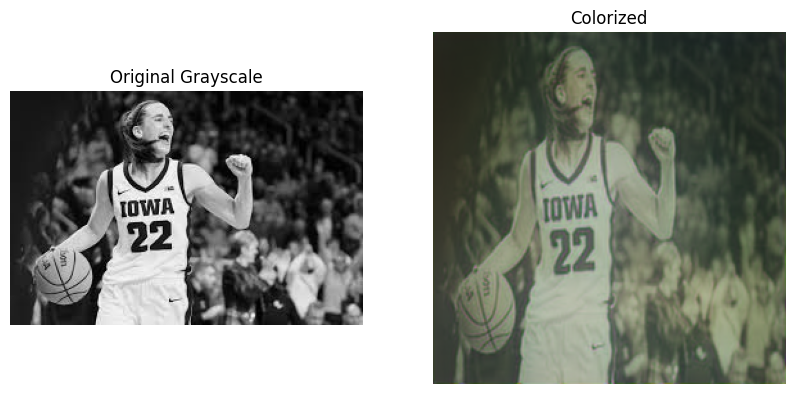

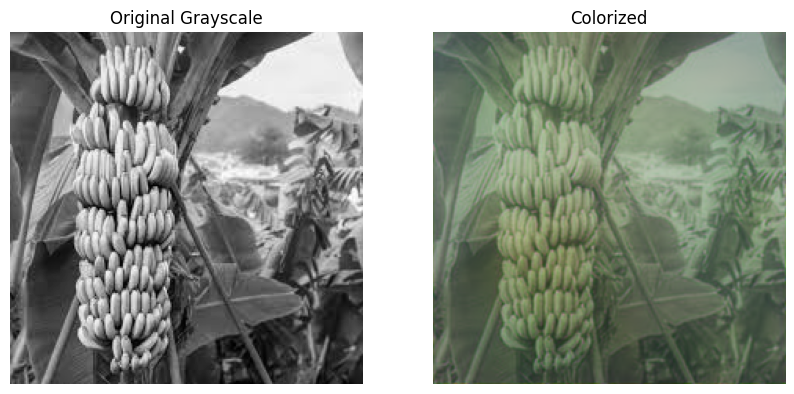

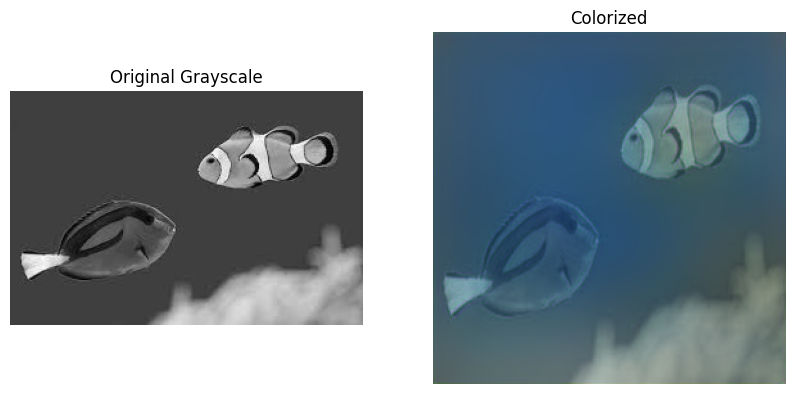

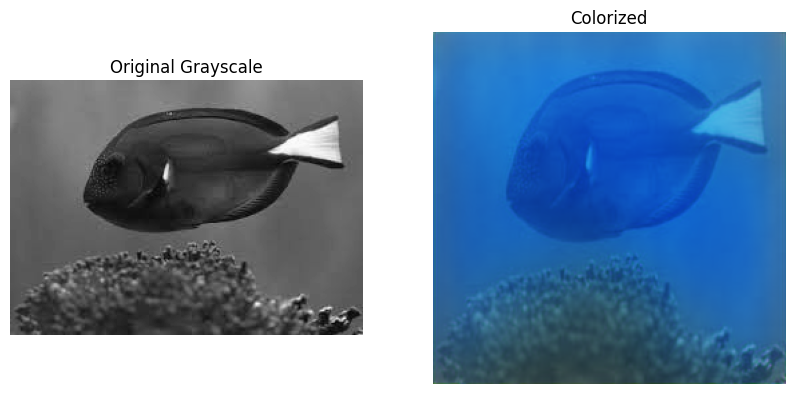

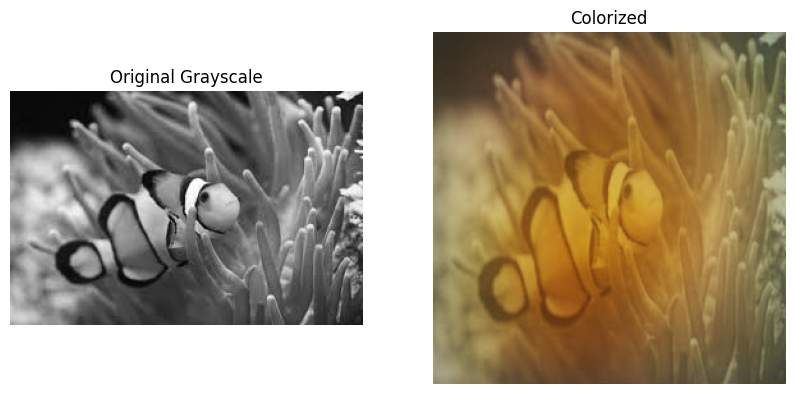

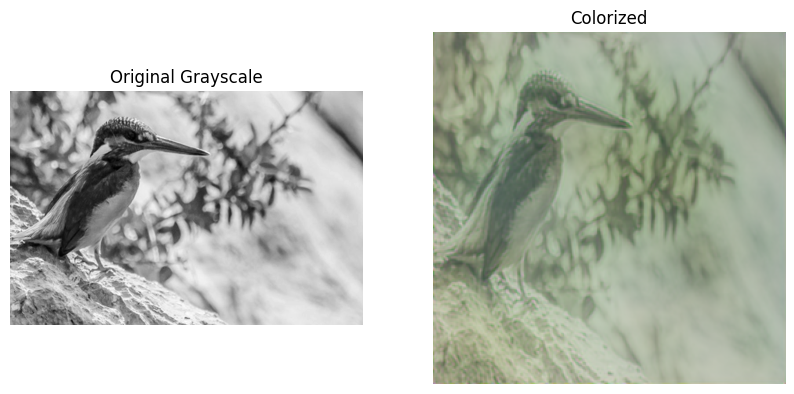

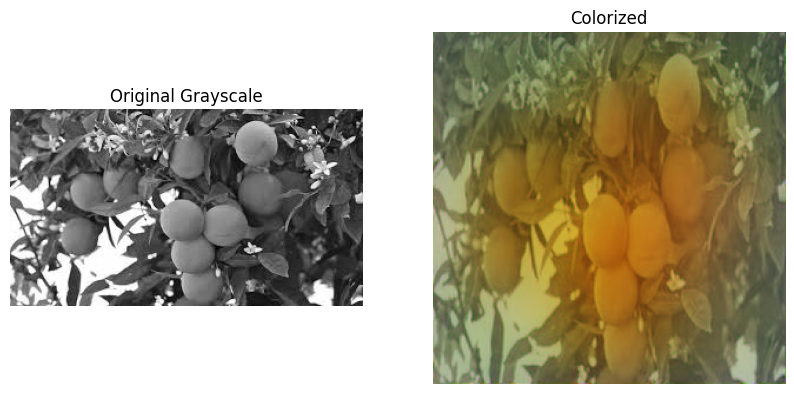

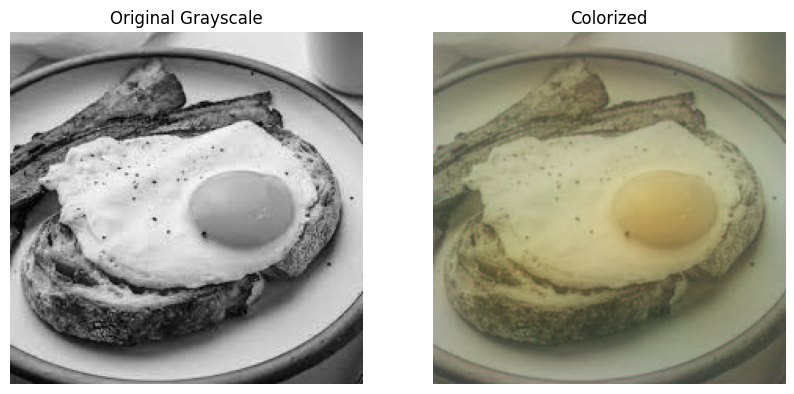

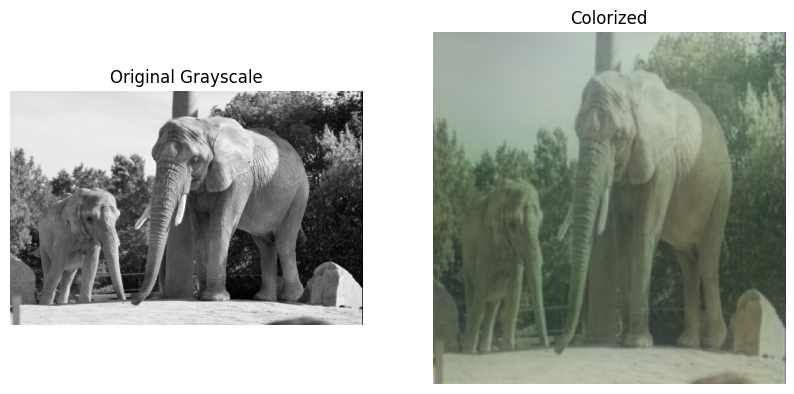

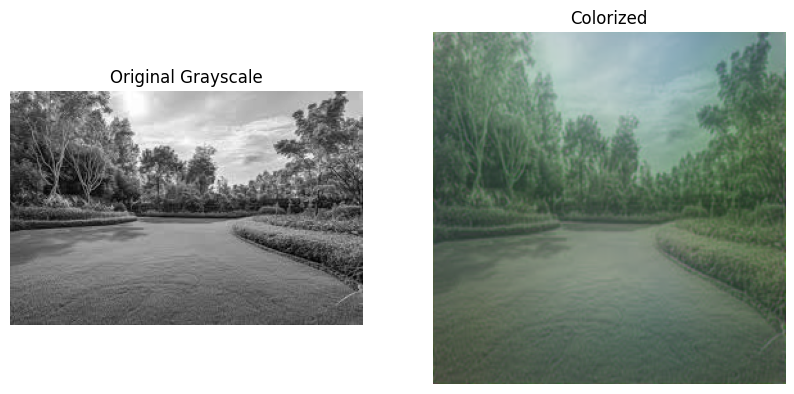

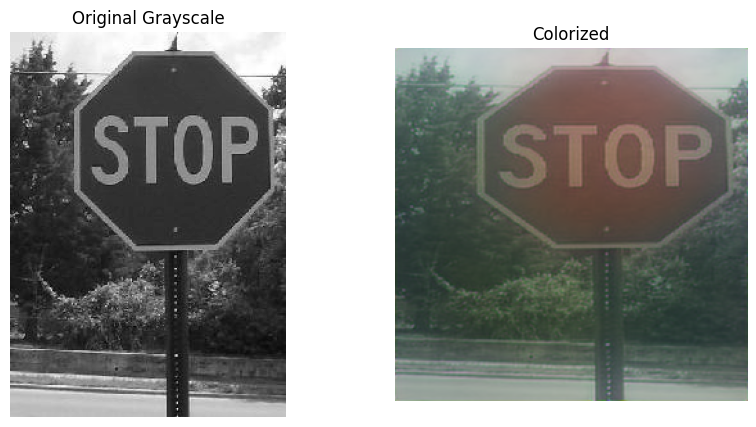

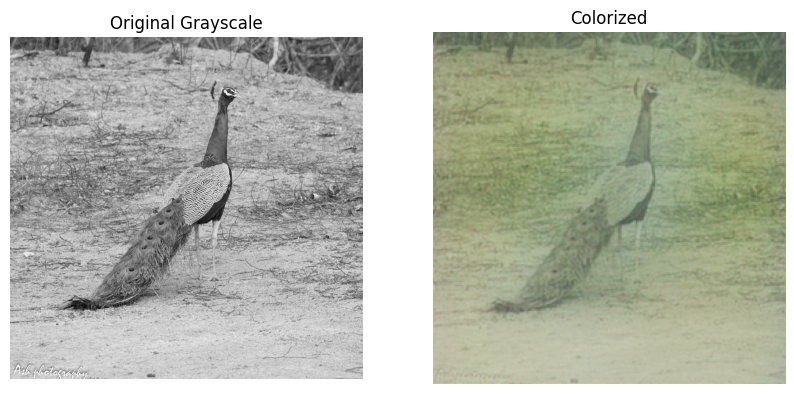

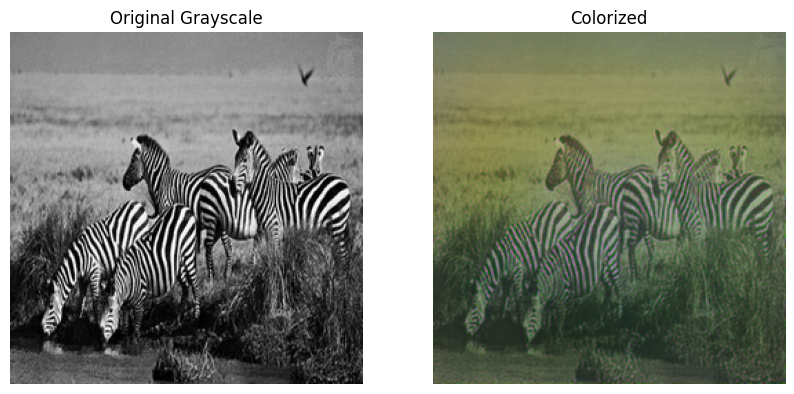

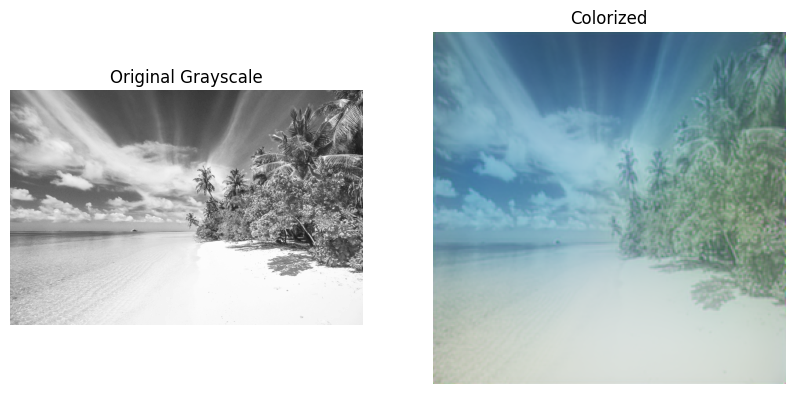

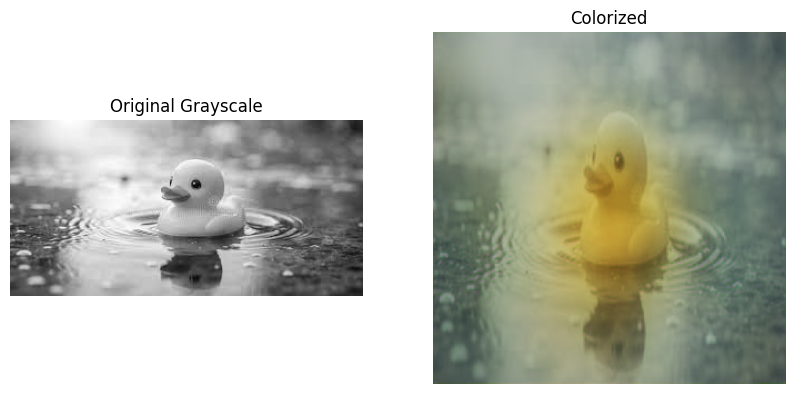

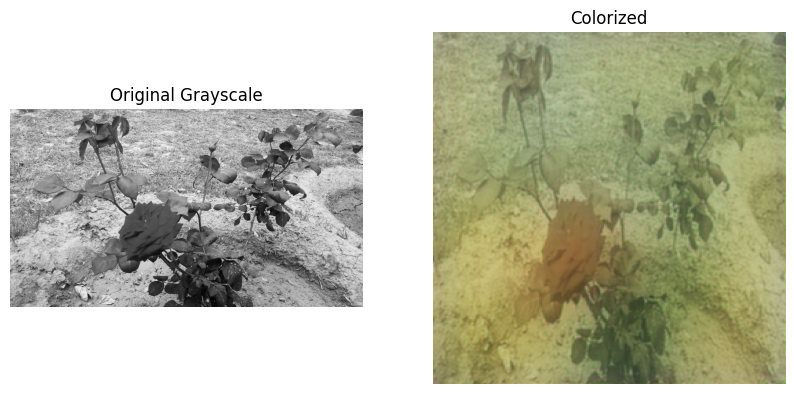

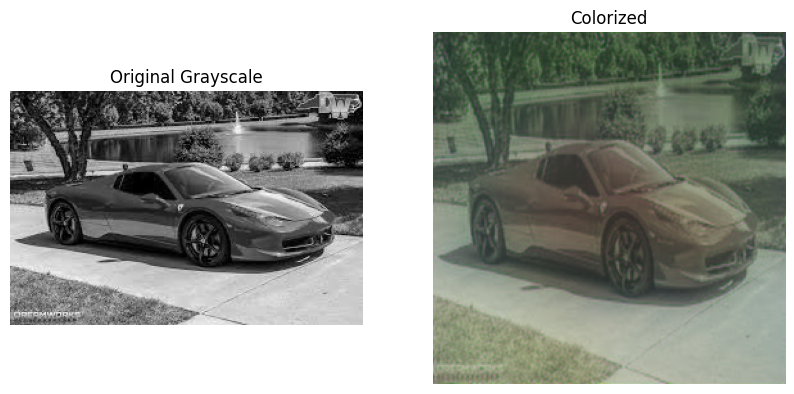

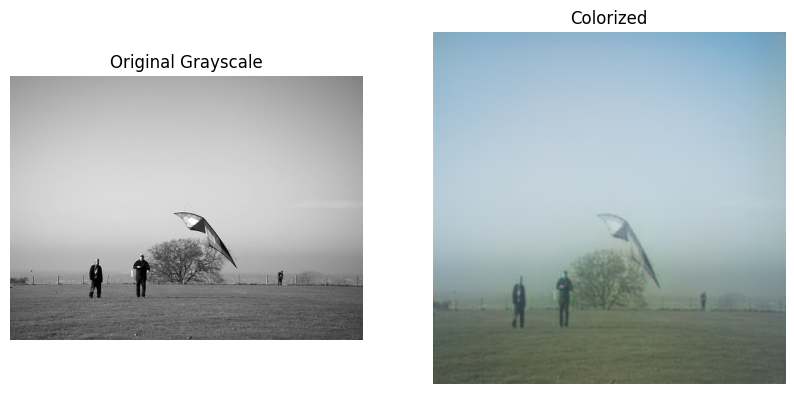

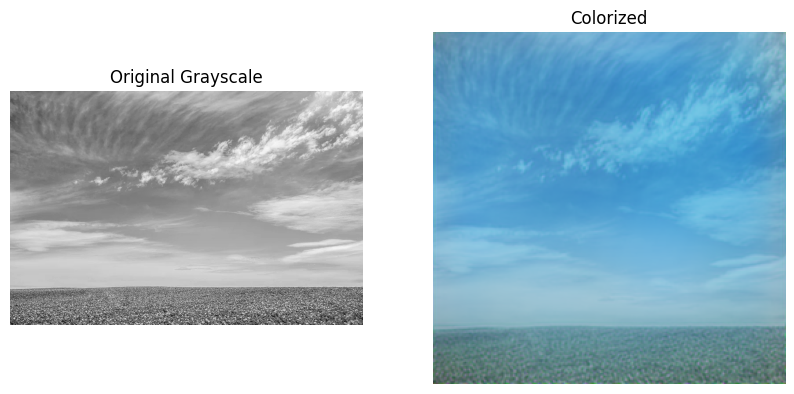

In [10]:
import torch
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from PIL import Image
import matplotlib.pyplot as plt

def colorize_image(model, input_image_path):
    # Prepare the input image
    transform = Compose([
        Resize((256, 256)),
        ToTensor(),
        Normalize(mean=[0.5], std=[0.5])
    ])

    input_image = Image.open(input_image_path).convert("L")
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Colorize the image
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # Convert the output tensor to a numpy array
    output_image = output.squeeze().cpu().permute(1, 2, 0).numpy()
    output_image = (output_image * 0.5 + 0.5).clip(0, 1)

    # Display the original and colorized images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(input_image, cmap='gray')
    ax1.set_title("Original Grayscale")
    ax1.axis('off')
    ax2.imshow(output_image)
    ax2.set_title("Colorized")
    ax2.axis('off')
    plt.show()

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetUNet().to(device)
model.load_state_dict(torch.load("colorization_model.pth", map_location=device))

input_image_path = r"Real images\ba1 (2).jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\banana_tree.jpeg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\bt (1).jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\bt (7).jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\cf (11).jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\Common-Kingfisher_18.jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\download (15).jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\egg (2).jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\el (20).jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\grass.jpeg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\image_0052.jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\Indian-Peacock_157.jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\n02391049_141.jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\pexels-asadphoto-457878.jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\rd (18).jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\Red Rose New (21).jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\rf (6).jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\sky_image_2.jpg"
colorize_image(model, input_image_path)
input_image_path = r"Real images\sky_image.jpeg"
colorize_image(model, input_image_path)

In [11]:
import torch
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from PIL import Image
import os

def save_colorized_image(model, input_image_path, output_image_path):
    # Prepare the input image
    transform = Compose([
        Resize((256, 256)),
        ToTensor(),
        Normalize(mean=[0.5], std=[0.5])
    ])

    input_image = Image.open(input_image_path).convert("L")
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Colorize the image
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # Convert the output tensor to an image
    output_image = output.squeeze().cpu().permute(1, 2, 0).numpy()
    output_image = (output_image * 0.5 + 0.5).clip(0, 1)
    output_image = (output_image * 255).astype('uint8')

    # Save the colorized image
    output_pil = Image.fromarray(output_image)
    output_pil.save(output_image_path)
    print(f"Saved colorized image to {output_image_path}")

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetUNet().to(device)
model.load_state_dict(torch.load("colorization_model.pth", map_location=device))

# Define the output directory
output_dir = "EfficientNet_with_UNet_Resultant_images"
os.makedirs(output_dir, exist_ok=True)

# List of input grayscale image paths
input_image_paths = [
    r"Real images\ba1 (2).jpg",
    r"Real images\banana_tree.jpeg",
    r"Real images\bt (1).jpg",
    r"Real images\bt (7).jpg",
    r"Real images\cf (11).jpg",
    r"Real images\Common-Kingfisher_18.jpg",
    r"Real images\download (15).jpg",
    r"Real images\egg (2).jpg",
    r"Real images\el (20).jpg",
    r"Real images\grass.jpeg",
    r"Real images\image_0052.jpg",
    r"Real images\Indian-Peacock_157.jpg",
    r"Real images\n02391049_141.jpg",
    r"Real images\pexels-asadphoto-457878.jpg",
    r"Real images\rd (18).jpg",
    r"Real images\Red Rose New (21).jpg",
    r"Real images\rf (6).jpg",
    r"Real images\sky_image_2.jpg",
    r"Real images\sky_image.jpeg"
]

# Save colorized images
for input_image_path in input_image_paths:
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path).replace(".jpg", "_colorized.jpg").replace(".jpeg", "_colorized.jpeg").replace(".png", "_colorized.png"))
    save_colorized_image(model, input_image_path, output_image_path)

C:\Users\venka\AppData\Local\Temp\ipykernel_45504\104277795.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("colorization_model.pth", m

Saved colorized image to EfficientNet_with_UNet_Resultant_images\ba1 (2)_colorized.jpg
Saved colorized image to EfficientNet_with_UNet_Resultant_images\banana_tree_colorized.jpeg
Saved colorized image to EfficientNet_with_UNet_Resultant_images\bt (1)_colorized.jpg
Saved colorized image to EfficientNet_with_UNet_Resultant_images\bt (7)_colorized.jpg
Saved colorized image to EfficientNet_with_UNet_Resultant_images\cf (11)_colorized.jpg
Saved colorized image to EfficientNet_with_UNet_Resultant_images\Common-Kingfisher_18_colorized.jpg
Saved colorized image to EfficientNet_with_UNet_Resultant_images\download (15)_colorized.jpg
Saved colorized image to EfficientNet_with_UNet_Resultant_images\egg (2)_colorized.jpg
Saved colorized image to EfficientNet_with_UNet_Resultant_images\el (20)_colorized.jpg
Saved colorized image to EfficientNet_with_UNet_Resultant_images\grass_colorized.jpeg
Saved colorized image to EfficientNet_with_UNet_Resultant_images\image_0052_colorized.jpg
Saved colorized ima